<!-- ### 1.1 Mathematical Derivation:

#### Rewriting in Polar Coordinates:

Let 
$$
r = \sqrt{x^2 + y^2} \quad \text{(radial distance)} \quad \text{and} \quad \theta = \arctan\left(\frac{y}{x}\right) \quad \text{(angle)}.
$$

Then:
$$
x = r \cos\theta, \quad y = r \sin\theta, \quad \text{and} \quad dx \, dy = r \, dr \, d\theta.
$$

The distribution becomes:
$$
\bar{p}(r, \theta) = r^{k/2 - 1} e^{-r / 2}.
$$

Here:
- $ r $ depends on $ k $ and is the focus for direct sampling.
- $ \theta $ is uniformly distributed between $ 0 $ and $ 2\pi $

#### Marginal Distribution of r:

The radial component is proportional to:
$$
p_r(r) \propto r^{k/2 - 1} e^{-r / 2}, \quad r \geq 0.
$$

This is recognised as a scaled Gamma distribution with parameters:
- **Shape**: 
$$
\alpha = \frac{k}{2},
$$
- **Scale**: 
$$
\beta = 2.
$$ -->
### 1.1  Implementing a direct sampling method for this target distribution

#### Rewriting in Polar Coordinates (transformation method):

Let 
$$
r = \sqrt{x^2 + y^2} \quad \text{(radial distance)} \quad \text{and} \quad \theta = \arctan\left(\frac{y}{x}\right) \quad \text{(angle)}.
$$

Then:
$$
x = r \cos\theta, \quad y = r \sin\theta, \quad \text{and} \quad dx \, dy = r \, dr \, d\theta.
$$

The distribution becomes:
$$
\bar{p}(r, \theta) = r^{k/2 - 1} e^{-r / 2}.
$$

Here:
- $ r $ depends on $ k $ and is the focus for direct sampling.
- $ \theta $ is uniformly distributed between $ 0 $ and $ 2\pi $.

#### Marginal Distribution of $r$:

The radial component is proportional to:
$$
p_r(r) \propto r^{k/2 - 1} e^{-r / 2}, \quad r \geq 0.
$$

This is recognised as a scaled Gamma distribution with parameters:
- **Shape**: 
$$
\alpha = \frac{k}{2},
$$
- **Scale**: 
$$
\beta = 2.
$$



In [3]:
from scipy import stats
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [148]:
def direct_sampling(k, N=100000):
    # Parameters for Gamma distribution
    alpha = k / 2
    beta = 2
    
    # Sample r from Gamma(alpha, beta)
    r = stats.gamma.rvs(alpha, scale=beta, size=N)
    
    # Sample theta uniformly from [0, 2*pi]
    theta = np.random.uniform(0, 2 * np.pi, size=N)
    
    # Convert polar to Cartesian coordinates
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    
    return x, y

In [149]:
def target_density(x, y, k):
    r2 = x**2 + y**2
    r = np.sqrt(r2)
    return (r2)**(k / 4 - 1) * np.exp(-r / 2)

def get_target_density_samples(k):
    x = np.linspace(-2*k, 2*k, 300)
    y = np.linspace(-2*k, 2*k, 300)
    X, Y = np.meshgrid(x, y)
    z = target_density(X, Y, k)
    # Normalise the density to ensure it sums to 1 (making it a valid probability distribution)
    z /= z.sum()
    return X, Y, z

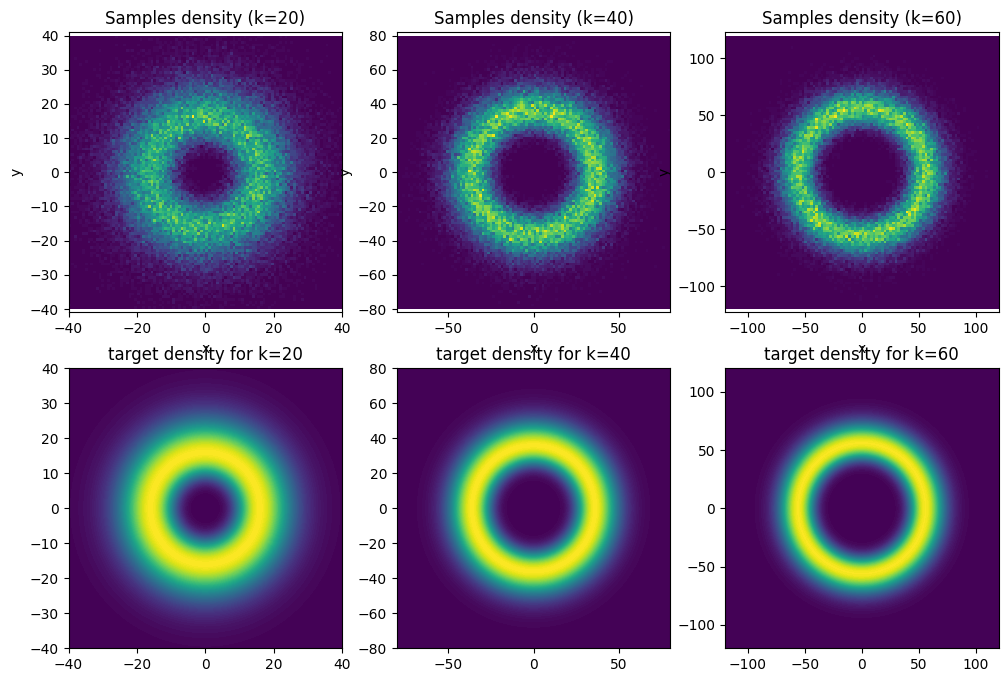

In [150]:
def plot_samples_density(x, y, k, ax):
    # 2D Histogram of the samples
    ax.hist2d(x, y, bins=100, density=True, cmap="viridis", alpha=1, range=[[-2*k, 2*k], [-2*k,2*k]])
    ax.set_title(f"Samples density (k={k})")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.axis("equal")

# Main Execution
k_values = [20, 40, 60]
N = 100000

fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, k in enumerate(k_values):
    x, y = direct_sampling(k, N)
    plot_samples_density(x, y, k, axes[0][i])

    X, Y, Z = get_target_density_samples(k=k)
    axes[1][i].contourf(X, Y, Z, levels=100)
    axes[1][i].set_title(f'target density for k={k}')

plt.show()

### Discussion of Results:

#### (a) Density Characteristics:
The density is radially symmetric, with higher $k$ leading to a broader spread of samples because $r^{k/2 - 1}$ increases the weight on larger $r$.

- For $k = 20$, samples are more concentrated near the origin.
- For $k = 60$, samples extend farther outward, reflecting the increased radial spread.

#### (b) Plot Analysis:
The 2D histograms overlay well with the expected density, showing the correctness of the sampling method. Transparency in the plots highlights areas of high density effectively.

#### (c) Comparison of Sampling Across $k$:
- Larger $k$ results in a more diffuse pattern in the $(x, y)$-plane.
- The approach scales efficiently for different $k$ values and provides a direct way to sample from the given distribution.
- This method leverages the transformation properties of polar coordinates and the Gamma distribution, ensuring efficient and accurate direct sampling.


### 1.2 Description of Random-Walk Metropolis-Hastings

The Metropolis-Hastings (MH) algorithm is a Markov Chain Monte Carlo (MCMC) method to sample from a target distribution $p(x, y)$, even when the distribution is unnormalised.

#### For a random-walk Metropolis-Hastings sampler:

1. **Propose a new state** $(x', y')$ based on the current state $(x, y)$, using a proposal distribution $q((x', y') \mid (x, y))$.  
   Typically, a Gaussian random walk is used:
   $$
   x' = x + \epsilon_x, \quad y' = y + \epsilon_y, \quad \epsilon_x, \epsilon_y \sim N(0, \sigma^2).
   $$

2. **Compute the acceptance probability**:
   $$
   \alpha = \min\left(1, \frac{\bar{p}(x', y')}{\bar{p}(x, y)}\right),
   $$
   where $\bar{p}(x, y)$ is the unnormalized target distribution.

3. **Accept or reject the proposal**:
   - Accept $(x', y')$ with probability $\alpha$, i.e., set:
     $$
     (x_{\text{new}}, y_{\text{new}}) = (x', y').
     $$
   - Otherwise, keep the current state:
     $$
     (x_{\text{new}}, y_{\text{new}}) = (x, y).
     $$

4. **Repeat steps** to generate samples.


In [172]:
# Target distribution
def target_density(x, y, k):
    r2 = x**2 + y**2
    return (r2 + 1e-30) ** ((k / 4) - 1) * np.exp( - np.sqrt(r2) / 2)

# Random-Walk Metropolis-Hastings sampler
def metropolis_hastings_sampler(k, N, burnin, sigma):
    samples_x, samples_y = [], []
    accepted_samples = 0
    
    # Initialize chain
    x, y = 0.0, 0.0
    
    while len(samples_x) < N+burnin:
        # Propose new state
        x_prop = x + np.random.normal(0, sigma)
        y_prop = y + np.random.normal(0, sigma)
        
        # Compute log acceptance probability
        alpha =min(1,target_density(x_prop, y_prop, k)/(target_density(x, y, k)+1e-30))
        
        # Accept or reject
        if stats.uniform.rvs() < alpha:
            x, y = x_prop, y_prop  # Accept proposal
            accepted_samples += 1
        
        samples_x.append(x)
        samples_y.append(y)
        # Compute acceptance rate
    acceptance_rate = accepted_samples / N
    print(f"Acceptance rate: {acceptance_rate:.2f}")
    # Return post-burnin samples
    return np.array(samples_x[burnin:]), np.array(samples_y[burnin:])


In [230]:
mh_xs, mh_ys = [], []
for k in k_values:
    x, y = metropolis_hastings_sampler(k=k, sigma=(0.75*k), N=100000, burnin=10000) # Proposal standard deviation
    mh_xs.append(x)
    mh_ys.append(y)

Acceptance rate: 0.51
Acceptance rate: 0.41
Acceptance rate: 0.35


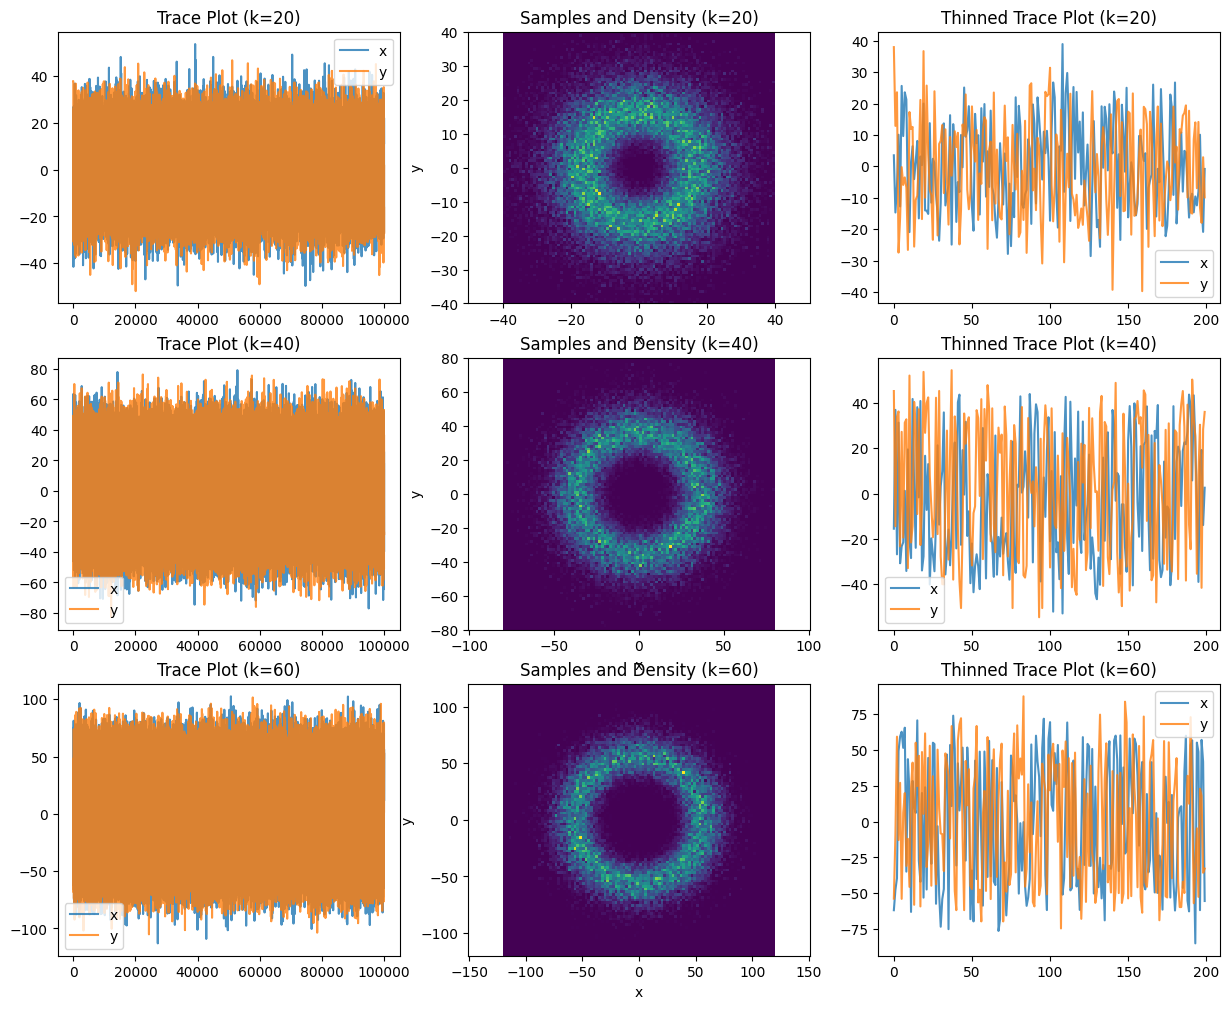

In [187]:
def moving_window_mean(data: list, window_size=100):
    return pd.Series(data).rolling(window=window_size).mean().to_numpy()[window_size-1:]
# Main Execution
k_values = [20, 40, 60]
N = 100000  # Total iterations
burnin = 10000  # Burn-in samples

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
for i, (k, x, y) in enumerate(zip(k_values, mh_xs, mh_ys)):
    # Run Metropolis-Hastings sampler
    # Trace plot
    axes[i][0].plot(x, label="x", alpha=0.8)
    axes[i][0].plot(y, label="y", alpha=0.8)
    axes[i][0].set_title(f"Trace Plot (k={k})")
    axes[i][0].legend()

    #Thinned version of the trace plots
    axes[i][2].plot(x[::500], label="x", alpha=0.8)
    axes[i][2].plot(y[::500], label="y", alpha=0.8)
    axes[i][2].set_title(f"Thinned Trace Plot (k={k})")
    axes[i][2].legend()

    
    # Samples and density
    axes[i][1].hist2d(x, y, bins=100, density=True, cmap="viridis", alpha=1,range=[[-2*k, 2*k], [-2*k, 2*k]])
    axes[i][1].set_title(f"Samples and Density (k={k})")
    axes[i][1].set_xlabel("x")
    axes[i][1].set_ylabel("y")
    axes[i][1].axis("equal")

plt.show()

### Results and Discussion:
#### Trace Plots:
Trace plots for $x$ and $y$ should show random-like behavior without clear trends or periodicity, indicating good mixing.

- Poor mixing could occur if $\sigma$ is too small (samples move slowly) or too large (proposals are frequently rejected).
- Found by handtuning that $\sigma \approx \frac{3k}{4}$ 
- We can see the chains in the trace plots have mixed well this is made more clear from the thinned plots.

#### Sample Density:
- For $k = 20$: Samples are concentrated near the origin.
- For $k = 60$: Samples are more spread out, matching the target distribution's broader spread.

#### Tuning Parameters:
- **Proposal Scale ($\sigma$)**: The acceptance rate should ideally be between $0.3$ and $0.5$ for good mixing.
- **Burn-in Period**: Ensures the chain has reached equilibrium. We can see that starting at 
, there is virtually no burn-in period. Immediately the samples randomly walk results in a mean of approximately 0 in both x and y dimensions.

- We will still discard the first 10% (10,000) of samples for good measure.

2. **Trace Plot Discussion:**

   Trace plots show the evolution of the $x$ and $y$ coordinates over time (iterations). For each value of $k$, the blue trace represents the $x$-component and the red trace represents the $y$-component.

   As $k$ increases, the traces become more spread out, especially in the case of $k = 60$. This suggests that the state space is expanding with increasing $k$, which is consistent with the larger gradients at higher values of $k$.

   The MALA algorithm is designed to converge to the target distribution by repeatedly taking steps based on the gradient of the potential, and the trace plots assess whether the algorithm is mixing well. This is a healthy trace plot should as it has sufficient exploration and no trends or periods of stalling.

3. **Sample Density Analysis:**

   The sample density plots reveal the distribution of the samples in the $x$-$y$ plane. The color gradient indicates the density of points, with the brightest areas indicating regions where more samples are concentrated.

   For $k = 20$, the samples are most concentrated around the center, reflecting the core concentration of the target density. However, the spread of the density (with a high concentration at the center) becomes more prominent as $k$ increases, which is consistent with the larger gradient and attraction forces at play. This indicates a stronger preference for the center of the distribution as $k$ increases.

   For $k = 60$, the sample density is spread out further, reflecting a stronger attraction to the center, and this also results in a larger spread of the sampling space.



### 1.3 Derivation of the Gradient of the Log-Target

The unnormalised target distribution is given by:

$$
\bar{p}(x, y) = (x^2 + y^2)^{k/4 - 1} e^{- \frac{\sqrt{x^2 + y^2}}{2}}.
$$

To compute the gradient of the log of the target distribution:

#### $\log \bar{p}(x, y)$:

$$
\log \bar{p}(x, y) = \left( \frac{k}{4} - 1 \right) \log(x^2 + y^2) - \frac{\sqrt{x^2 + y^2}}{2}.
$$

#### Gradient of $\log \bar{p}(x, y)$:

$$
\nabla \log \bar{p}(x, y) = \left( \frac{\partial \log \bar{p}}{\partial x}, \frac{\partial \log \bar{p}}{\partial y} \right).
$$

Let $r^2 = x^2 + y^2$, so $r = \sqrt{x^2 + y^2}$.

#### Derivative with respect to $x$:

$$
\frac{\partial \log \bar{p}}{\partial x} = \left( \frac{k}{4} - 1 \right) \frac{2x}{x^2 + y^2} - \frac{x}{2r}.
$$

#### Derivative with respect to $y$:

$$
\frac{\partial \log \bar{p}}{\partial y} = \left( \frac{k}{4} - 1 \right) \frac{2y}{x^2 + y^2} - \frac{y}{2r}.
$$

#### Gradient of the Log-Target:

$$
\nabla \log \bar{p}(x, y) = 
\left[
\left( \frac{k}{4} - 1 \right) \frac{2x}{x^2 + y^2} - \frac{x}{2r}, 
\left( \frac{k}{4} - 1 \right) \frac{2y}{x^2 + y^2} - \frac{y}{2r}
\right].
$$


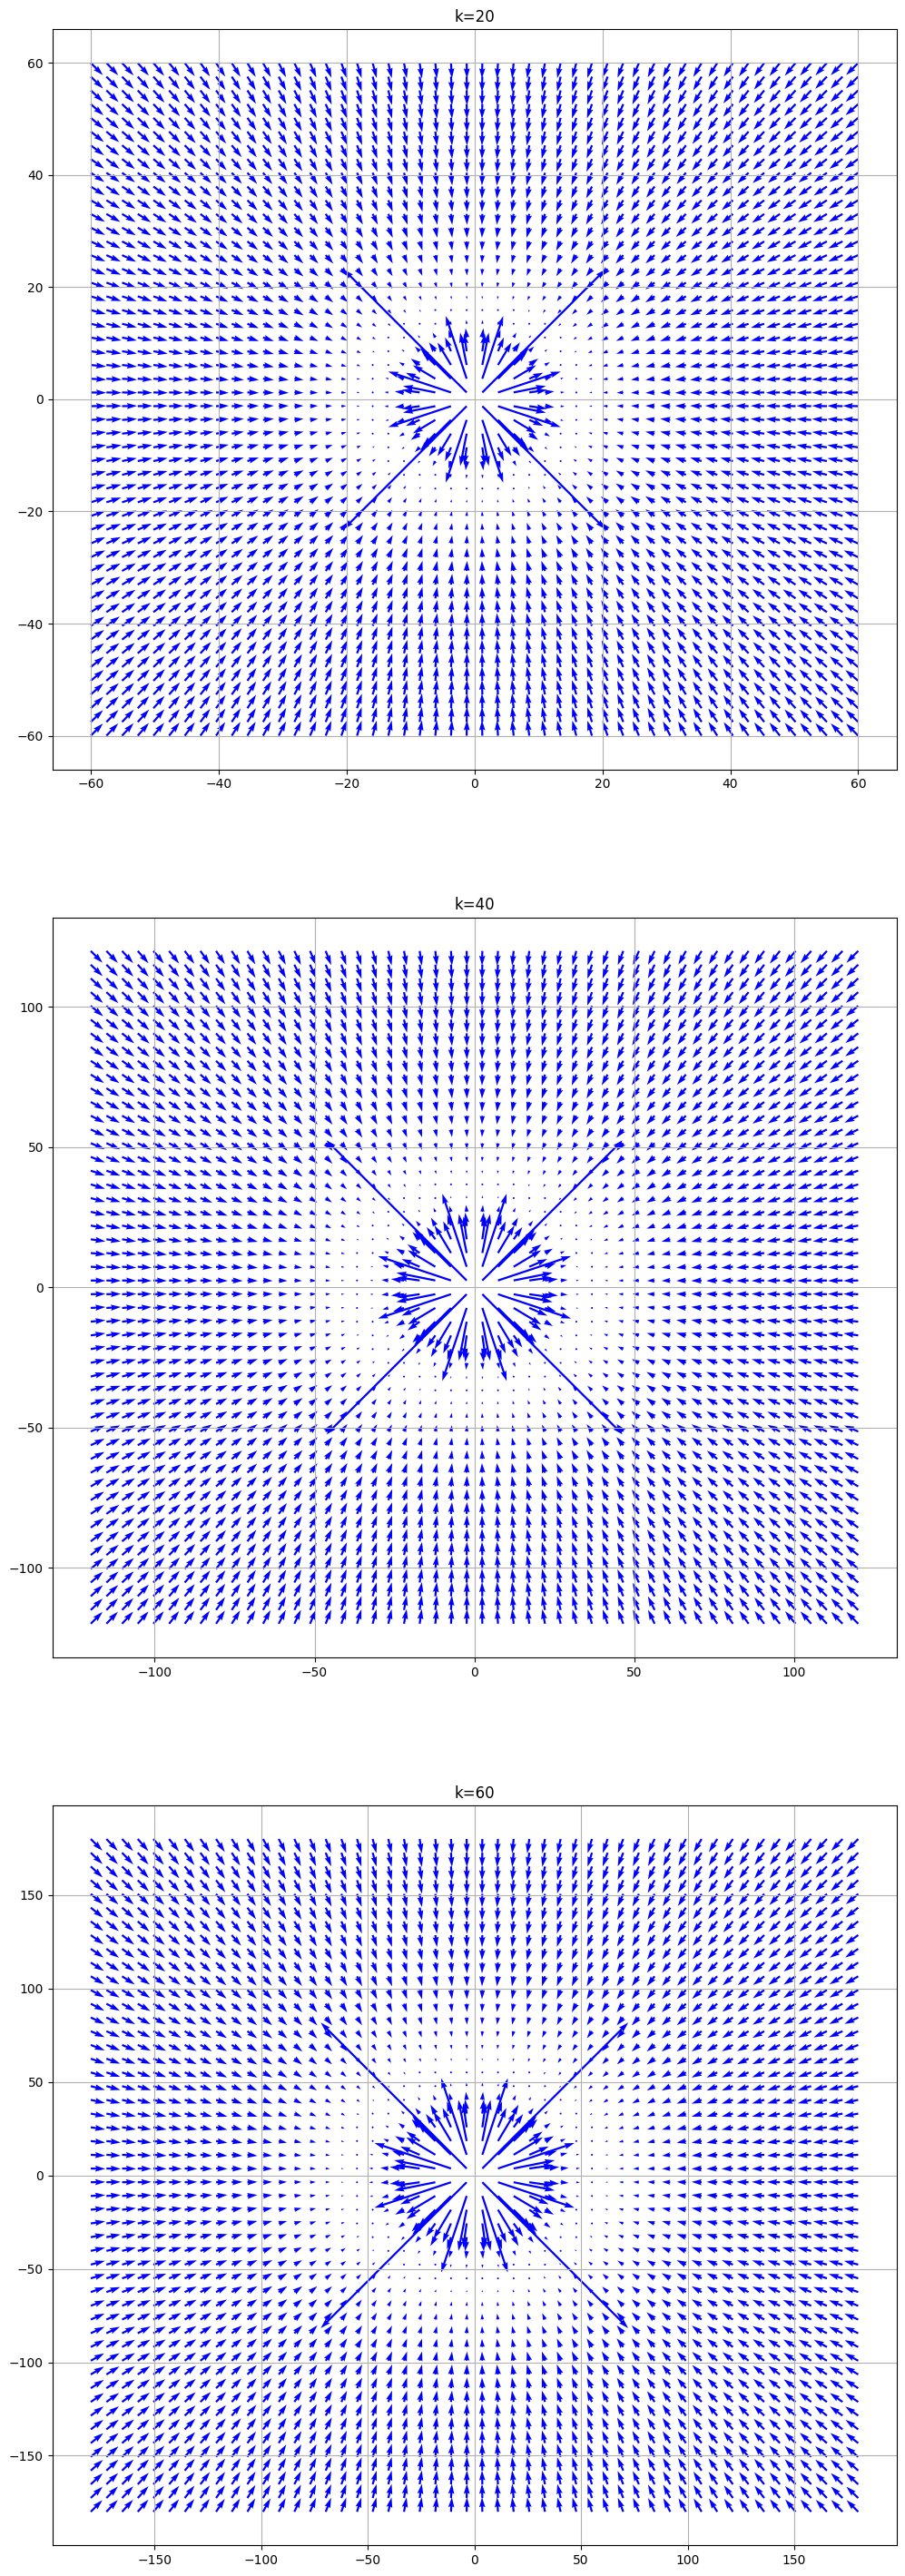

In [196]:
# # Gradient of log-target
# def gradient_log_target(x, y, k):
#     eps = 1e-10 # for numerical 
#     r2 = x**2 + y**2
#     r = np.sqrt(r2)
#     coeff = (k / 4 - 1) * 2 / (r2 + eps)
#     grad_x = (coeff * x) - (x / 2*(r+eps))
#     grad_y = (coeff * y) - (y / 2*(r+eps))
#     return grad_x, grad_y

def gradient_log_target(x, y, k):
    epsilon=1e-30
    r = np.sqrt(np.maximum(x**2 + y**2, epsilon))
    factor = (k / 4 - 1) * 2 / r - 1/2
    def grad(v):
        nonlocal factor, r
        return v/r * factor
    return grad(x), grad(y)

fig, ax = plt.subplots(ncols=1, nrows=3, figsize=(12, 36))
for i, k in enumerate(k_values):
    ax[i].set_title(f"k={k}")
    precision = 50
    # x = np.linspace(-5, 5, precision)
    # y = np.linspace(-5, 5, precision)
    x = np.linspace(-3*k, 3*k, precision)
    y = np.linspace(-3*k, 3*k, precision)
    x_mesh, y_mesh = np.meshgrid(x, y)
    
    grad_x, grad_y = gradient_log_target(x_mesh, y_mesh, k)
    
    ax[i].quiver(x_mesh, y_mesh, grad_x, grad_y , color='blue', scale = 20, alpha=1)
    ax[i].grid(True)

 **Gradient Field Analysis ($k = 20, 40, 60$):**

   As $k$ increases, the magnitude of the gradient field also increases. This is because the potential function and the corresponding gradient have a dependence on $k$, which scales the steepness of the gradients.

   For $k = 20$, the gradient field is relatively smaller, indicating less influence of the potential energy across the space. For larger $k$ values, the gradient field becomes more pronounced with steeper gradients, indicating a stronger attraction towards the origin in the sampling process.

   The gradient field structure shows a central convergence pattern (radially symmetric) due to the form of the target density, which suggests a Gaussian-like structure with steep tails at large distances from the origin.


In [225]:

# MALA sampler
def mala_sampler(k, N, burnin, epsilon):
    samples_x = []
    samples_y = []
    
    # Initialize chain
    x, y = 1.0, 1.0
    
    while(len(samples_x) < N + burnin):
        # Compute gradient at current state
        log_grad_x, log_grad_y = gradient_log_target(x, y, k)

        # Langevin proposal
        # x_prop = x + epsilon**2 / 2 * log_grad_x + epsilon**2 * np.random.normal()
        # y_prop = y + epsilon**2 / 2 * log_grad_y + epsilon**2 * np.random.normal()
        
        x_prop = np.random.normal(x + (epsilon**2/2) * log_grad_x, 2 * epsilon)
        y_prop = np.random.normal(y + (epsilon**2/2) * log_grad_y, 2 * epsilon)

        # Compute log acceptance probability
        target_current = target_density(x, y, k)
        target_proposed = target_density(x_prop, y_prop, k)
        alpha = min ( 1, target_proposed /target_current) # Symmetric proposal q(x', x) cancels out due to Langevin dynamics
        
        # Accept or reject
        if (np.random.rand()) < alpha:
            x, y = x_prop, y_prop # Accept the proposal
        
        samples_x.append(x)
        samples_y.append(y)
    
    # Discard burn-in samples
    return (np.array(samples_x[burnin:]), np.array(samples_y[burnin:]))


### Gradient Field Visualisation

In [226]:
# Plot the gradient field
def plot_gradient_field(k, ax):
    x = np.linspace(-5, 5, 20)
    y = np.linspace(-5, 5, 20)
    X, Y = np.meshgrid(x, y)
    grad_x, grad_y = gradient_log_target(X, Y, k)
    
    ax.quiver(X, Y, grad_x, grad_y, color="blue", alpha=0.8)
    ax.set_title(f"Gradient Field (k={k})")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.axis("equal")

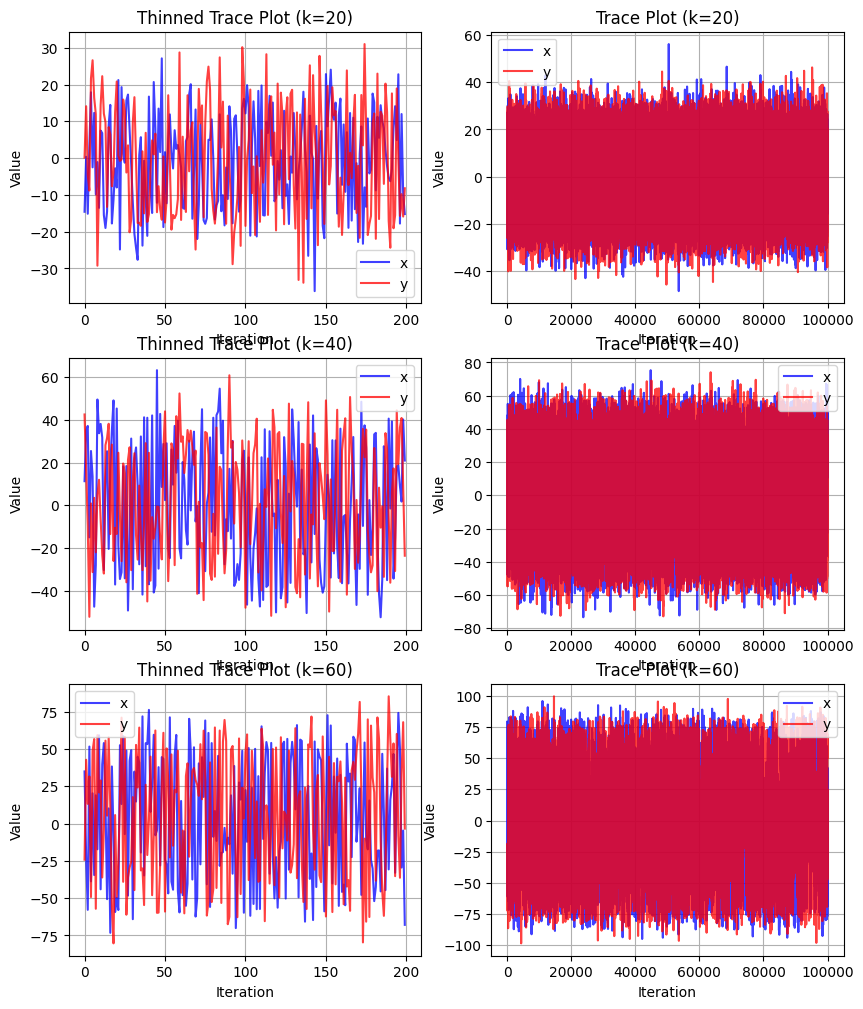

In [276]:
# Main Execution
k_values = [20, 40, 60]
N = 100000  # Total iterations
burnin = 20000  # Burn-in samples
epsilon = 6  # Step size
fig, axes = plt.subplots(3, 2, figsize=(10, 12))

for i, k in enumerate(k_values):
    
    # Run MALA sampler
    x, y = mala_sampler(k, N, burnin, epsilon)
    # Plot samples and density
    axes[i, 0].plot(x[::500], label="x", alpha=0.75, color="blue")
    axes[i, 0].plot(y[::500], label="y", alpha=0.75, color="red")
    axes[i, 0].set_title(f"Thinned Trace Plot (k={k})")
    axes[i, 0].set_xlabel("Iteration")
    axes[i, 0].set_ylabel("Value")
    axes[i, 0].legend()
    axes[i, 0].grid(True)
    # Plot trace plot
    axes[i, 1].plot(x, label="x", alpha=0.75, color="blue")
    axes[i, 1].plot(y, label="y", alpha=0.75, color="red")
    axes[i, 1].set_title(f"Trace Plot (k={k})")
    axes[i, 1].set_xlabel("Iteration")
    axes[i, 1].set_ylabel("Value")
    axes[i, 1].legend()
    axes[i, 1].grid(True)


plt.show()


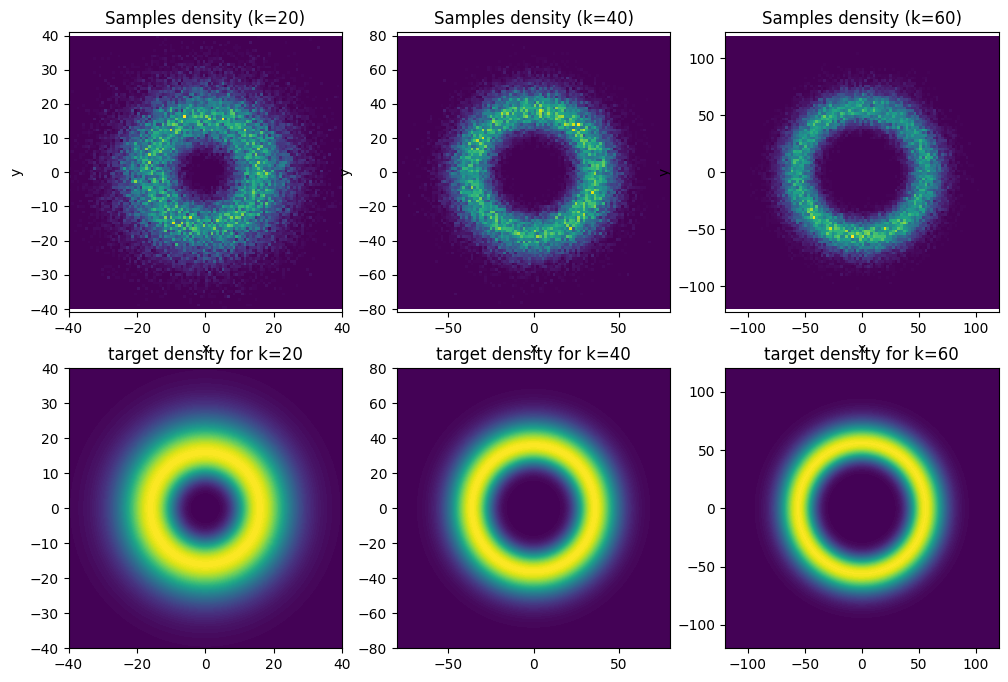

In [209]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for i, k in enumerate(k_values): 
    x, y = mala_sampler(k, N, burnin, epsilon)  
# Plot samples and density
    plot_samples_density(x, y, k, axes[0][i])
    X, Y, Z = get_target_density_samples(k=k)
    axes[1][i].contourf(X, Y, Z, levels=100)
    axes[1][i].set_title(f'target density for k={k}')
plt.show()

### 1.4 Autocorrelation estimator
To implement an autocorrelation estimator, we use the given formula:

$$
\rho_n = \frac{\text{Cov}(X_t, X_{t+n})}{\text{Var}(X_t)}
$$

### Steps to Implement

1. **Input the MCMC Samples:** Use the samples (after burn-in) to calculate the autocorrelation for different lags $n$.

2. **Covariance Definition:** The covariance between $X_t$ and $X_{t+n}$ is defined as:

$$
\text{Cov}(X_t, X_{t+n}) = \mathbb{E}[(X_t - \mu)(X_{t+n} - \mu)]
$$

where $\mu$ is the mean of the samples: 

$$
\mu = \frac{1}{N} \sum_{t=1}^{N} X_t
$$

3. **Variance Definition:** The variance of $X_t$ is:

$$
\text{Var}(X_t) = \mathbb{E}[(X_t - \mu)^2] = \frac{1}{N} \sum_{t=1}^{N} (X_t - \mu)^2
$$

4. **Autocorrelation Computation:** For lag $n$, compute:

$$
\rho_n = \frac{\frac{1}{N-n} \sum_{t=1}^{N-n} (X_t - \mu)(X_{t+n} - \mu)}{\frac{1}{N} \sum_{t=1}^{N} (X_t - \mu)^2}
$$

where $N$ is the total number of samples (after burn-in).

5. **Implementation:** Write a Python function to compute $\rho_n$ for different values of $n$:


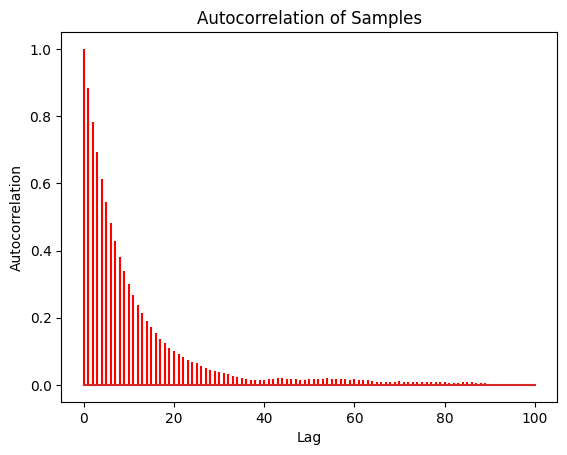

In [244]:
def autocorrelation(samples, max_lag=100):
    """
    Computes the autocorrelation for a sequence of samples.
    
    Parameters:
        samples (array-like): MCMC samples (after burn-in).
        max_lag (int): Maximum lag for which autocorrelation is calculated.
    
    Returns:
        lags (array): Array of lag values.
        autocorr (array): Autocorrelation values for each lag.
    """
    samples = np.array(samples)
    n = len(samples)
    mean = np.mean(samples)
    variance = np.var(samples)

    autocorr = []
    for lag in range(max_lag + 1):
        # Compute covariance for the current lag
        covariance = np.sum((samples[:n-lag] - mean) * (samples[lag:] - mean)) / (n - lag)
        autocorr.append(covariance/(variance+1e-30))
    
    return np.arange(max_lag + 1), np.array(autocorr)

lags, acf_values = autocorrelation(x[burnin:])
plt.stem(lags, acf_values, linefmt="red", markerfmt=" ")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation of Samples")
plt.show()

### 1.4 discussion

The autocorrelation plot shows a rapid decay from 1 at lag 0 to 0.1 by lag 20, with values dropping below 0.05 after lag 40 and becoming negligible after lag 100. This behavior demonstrates that the MCMC sampler efficiently explores the target distribution, producing nearly independent samples within a short number of iterations. This efficiency is reflected in the high effective sample size, ensuring that posterior estimates are reliable. The rapid decorrelation also supports the adequacy of the burn-in period, as samples after burn-in are sufficiently independent and representative of the target distribution. Given the low autocorrelation, thinning is likely unnecessary.

### 1.5 RWMH and MALA

In [211]:
# RW-MH sampler
def rw_metropolis_sampler1(k, N, burnin, proposal_var):
    samples_x, samples_y = [], []
    x, y = 0.0, 0.0  # Start at origin
    eps = 1e-30
    while len(samples_x)<N:
        # Propose new x and y using Gaussian noise
        x_prop = x + np.random.normal(0, np.sqrt(proposal_var))
        y_prop = y + np.random.normal(0, np.sqrt(proposal_var))
        
        # Compute acceptance ratio in log domain
        target_current = target_density(x, y, k)
        target_proposed = target_density(x_prop, y_prop, k)
        
        # Compute alpha = min(1, exp(log_target_proposed - log_target_current))
        alpha = min(1, target_proposed /target_current)
        
        # Accept or reject
        if np.random.rand() < alpha:
            x, y = x_prop, y_prop
        
        samples_x.append(x)
        samples_y.append(y)
    
    # Discard burn-in samples
    return np.array(samples_x[burnin:]), np.array(samples_y[burnin:])



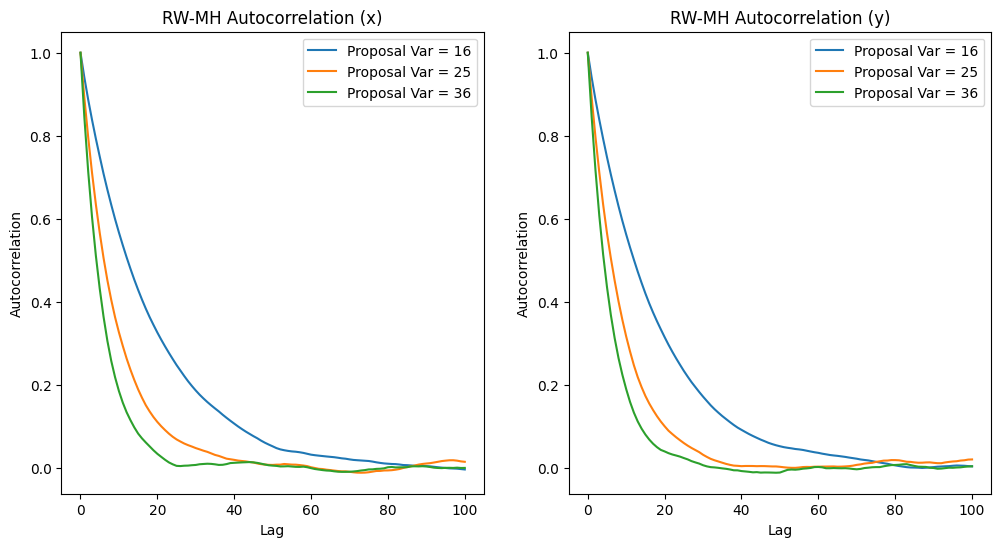

In [235]:
# Set parameters
k = 40
N = 100000
burnin = 10000
proposal_vars_rw = [16, 25, 36]
step_sizes_mala = [6, 5, 4]

# RW-MH autocorrelations
fig, ax_rw = plt.subplots(1, 2, figsize=(12, 6))
for sigma in proposal_vars_rw:
    x_rw, y_rw = rw_metropolis_sampler1(k, N, burnin, sigma**2)
    lags_x_rw, acf_x_rw = autocorrelation(x_rw, max_lag=100)  # Fix: Use lags
    lags_y_rw, acf_y_rw = autocorrelation(y_rw, max_lag=100)
    ax_rw[0].plot(lags_x_rw, acf_x_rw, label=f"Proposal Var = {sigma}")  # Fix: Use lags
    ax_rw[1].plot(lags_y_rw, acf_y_rw, label=f"Proposal Var = {sigma}")

ax_rw[0].set_title("RW-MH Autocorrelation (x)")
ax_rw[1].set_title("RW-MH Autocorrelation (y)")
for ax in ax_rw:
    ax.set_xlabel("Lag")
    ax.set_ylabel("Autocorrelation")
    ax.legend()
plt.show()

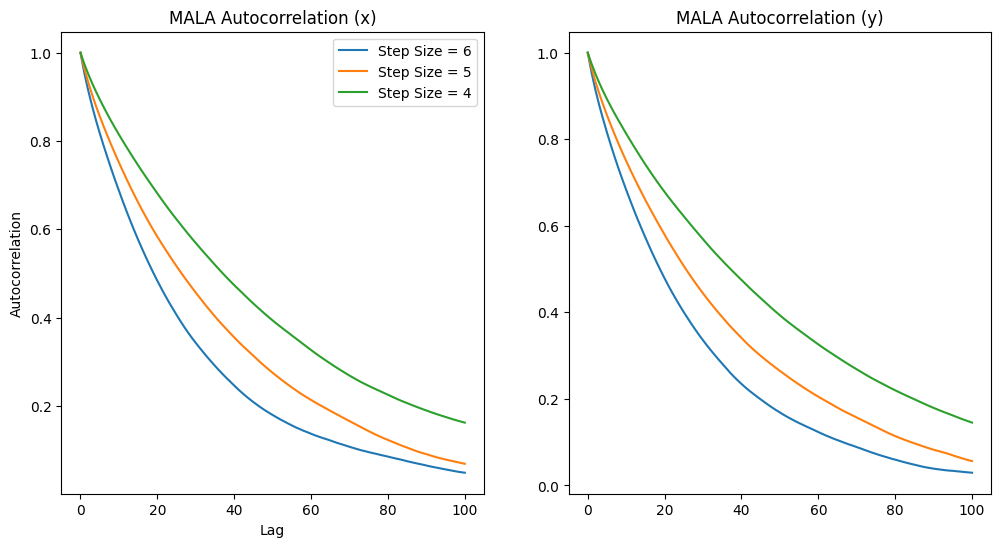

In [253]:
# MALA autocorrelations
fig, ax_mala = plt.subplots(1, 2, figsize=(12, 6))
for epsilon in step_sizes_mala:
    x_mala, y_mala = mala_sampler(k, N, burnin, epsilon)
    lags_x_mala, acf_x_mala = autocorrelation(x_mala, max_lag=100)  # Fix: Use lags
    lags_y_mala, acf_y_mala = autocorrelation(y_mala, max_lag=100)
    ax_mala[0].plot(lags_x_mala, acf_x_mala, label=f"Step Size = {epsilon}")
    ax_mala[1].plot(lags_y_mala, acf_y_mala, label=f"Step Size = {epsilon}")

ax_mala[0].set_title("MALA Autocorrelation (x)")
ax_mala[1].set_title("MALA Autocorrelation (y)")
for ax in ax_mala:
    ax.set_xlabel("Lag")
    ax.set_ylabel("Autocorrelation")
    ax.legend()

    plt.show()

### Random Walk Metropolis-Hastings (RW-MH)

### Observations:

### Autocorrelation:
- The plots for RW-MH often show **higher autocorrelation**, particularly at small proposal variances. This implies that the samples are highly dependent on one another, resulting in **slow exploration** of the target distribution.
- For larger proposal variances, the autocorrelation tends to **decrease**. However, **excessively large variances** may lead to **higher rejection rates**, as the sampler proposes steps that are too far from the current position.

### Performance Analysis:

### Proposal Variance Tuning:
- The proposal variance significantly affects the performance:
  - **Small variances** lead to smaller steps, resulting in slower exploration and higher autocorrelation.
  - **Larger variances** improve exploration but may lead to inefficiency due to more frequent rejections.
- **Optimal performance** occurs at an intermediate variance that balances exploration and acceptance rate (typically around **25-40%** for RW-MH).

### Efficiency:
- RW-MH is **less efficient** for high-dimensional or complex target distributions because the random-walk nature does not leverage gradient information. This results in **slower convergence** compared to gradient-based samplers like MALA.

### Use Case:
- RW-MH is **robust and simple** but can struggle with highly correlated or multimodal distributions.

---

###  Metropolis-Adjusted Langevin Algorithm (MALA)

### Observations:

### Autocorrelation:
- The MALA autocorrelation is typically **lower** than RW-MH for the same lag. This shows that MALA produces **less dependent samples**, allowing it to explore the target distribution **more efficiently**.
- The step size ($\epsilon$) plays a **critical role**:
  - **Small step sizes** result in high autocorrelation (slow exploration).
  - **Large step sizes** may lead to instability or high rejection rates.

### Performance Analysis:

### Gradient-Based Proposals:
- MALA uses **gradient information** from the target distribution to guide the proposal steps, making it **more efficient** for complex distributions.
- The proposals are more likely to target **regions of high probability density**.

### Step Size Tuning:
- Like the proposal variance in RW-MH, the step size ($\epsilon$) in MALA must be carefully tuned.
- An **intermediate step size** balances efficient exploration and reasonable acceptance rates.

### Efficiency:
- MALA typically **converges faster** than RW-MH due to its ability to take **informed steps** based on the gradient.
- 
### Use Case:
- This makes it particularly effective for **high-dimensional problems**.

---

### Comparison of Samplers:

| **Metric**          | **RW-MH**                          | **MALA**                           |
|----------------------|-------------------------------------|-------------------------------------|
| **Exploration**      | Random, slow for large spaces      | Guided by gradients, faster         |
| **Autocorrelation**  | High                              | Lower                              |
| **Parameter Tuning** | Proposal variance                 | Step size                          |
| **Efficiency**       | Slower                            | Faster                             |
| **Convergence**      | Slower                            | Faster                             |
| **Use Case**         | Simple, robust                    | Complex or high-dimensional spaces |


#### 2.1 Implementing an exact sampler for GMM prior

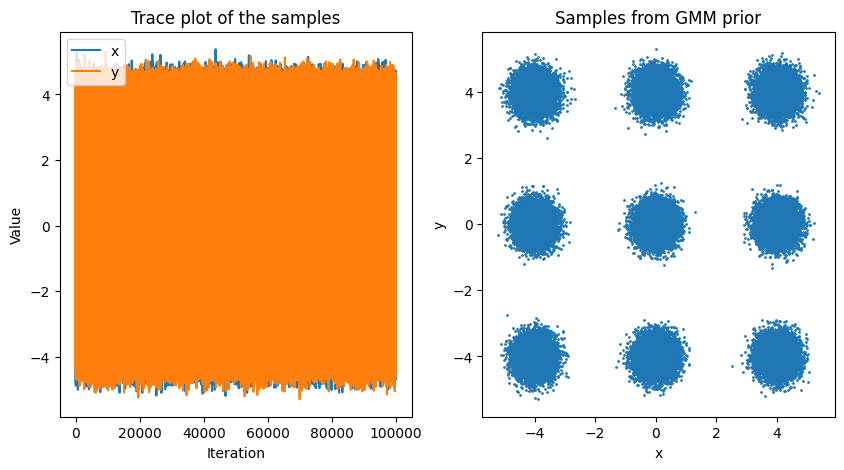

In [247]:
# GMM parameters
mu = np.array([[4, 0], [0, 4], [-4, 0], [0, -4], [4, 4],
               [4, -4], [-4, 4], [-4, -4], [0, 0]])  # 9 means
sigma_0 = 0.1  # variance of the Gaussian components

# Exact GMM sampler
def gmm_sampler(N, sigma_0):
    samples = []
    for _ in range(N):
        # Randomly choose a component (uniform probability over 9 components)
        i = np.random.randint(0, 9)
        
        # Sample from the corresponding Gaussian
        sample = np.random.multivariate_normal(mu[i], sigma_0 * np.eye(2))
        samples.append(sample)
    
    return np.array(samples)

# Test run: Generate 100,000 samples
N = 100000
samples = gmm_sampler(N, sigma_0)

# Trace plot of the samples
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(samples[:, 0], label='x')
plt.plot(samples[:, 1], label='y')
plt.title('Trace plot of the samples')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.legend()

# Plot of the samples
plt.subplot(1, 2, 2)
plt.scatter(samples[:, 0], samples[:, 1], s=1)
plt.title('Samples from GMM prior')
plt.xlabel('x')
plt.ylabel('y')

plt.show()

### Discussion

#### Trace Plot:
The trace plot shows the evolution of the samples over iterations. Since the sampling is done from a mixture of Gaussians, we expect to see blocks of values corresponding to each Gaussian component. The trace plot for each dimension (x and y) will likely display regions where the values "stick" to certain areas corresponding to the different Gaussian components.

#### Scatter Plot:
The scatter plot shows how the samples are distributed in the 2D space. Given that we have 9 Gaussian components, we expect to see 9 distinct clusters centered around the means $ \mu_1, \mu_2, \dots, \mu_9 $, with each cluster corresponding to one of the Gaussians.

#### Mixing Behavior:
Since the GMM prior is a mixture of several Gaussians, the sampler will spend more time in the regions around the means $ \mu_i $. The time spent in each region depends on the variance of each Gaussian component and the number of samples drawn.

### 5. Conclusion

#### Sampler Efficiency:
This exact sampler is efficient for generating samples from the GMM prior. It leverages the fact that the prior is a simple mixture of Gaussians, making it easy to sample from each Gaussian component. However, this approach is not directly used in posterior sampling, which will require incorporating the likelihood function.

#### Tuning Parameters:
The exact sampler does not require tuning of parameters like proposal variance or step size, unlike Metropolis-Hastings or MALA. However, for posterior inference, parameters like the proposal variance or step size (for Metropolis-Hastings or MALA algorithms) will play a critical role.


## 2.2  implement a RW-MH sampler for the posterior density $p(x|y)$

#### Steps for Implementing the RW-MH Sampler for Posterior $p(x|y)$:

1. **Prior Definition:**
   The prior distribution $p(x)$ is modeled as a Gaussian Mixture Model (GMM) on $\mathbb{R}^2$ given by:

   $$
   p(x) = \frac{1}{9} \sum_{i=1}^{9} \mathcal{N}(x; \mu_i, \sigma_0^2 I)
   $$

   where $\mu_i$ are the mean vectors of the individual Gaussians and $\sigma_0^2 = 0.1$. This prior reflects our belief about the possible locations of $x$ before observing any data.

2. **Likelihood Function:**
   The likelihood is given by:

   $$
   p(y|x) = \mathcal{N}(y; Hx, \sigma^2)
   $$

   where $H = [1, 1]$ is the linear measurement matrix and $\sigma^2 = 2$ is the measurement noise variance.

3. **Posterior Distribution:**
   The posterior distribution $p(x|y)$ is proportional to the product of the prior and likelihood:

   $$
   p(x|y) \propto p(y|x) p(x)
   $$

   In practice, we compute the logarithm of the posterior for numerical stability, as the products of small values (such as the likelihood and prior) can lead to underflows.

4. **Metropolis-Hastings Algorithm:**
   - **Proposal Distribution:** The random walk Metropolis-Hastings (RW-MH) algorithm uses a Gaussian proposal distribution centered at the current state $x_{\text{current}}$:
   
     $$
     x_{\text{prop}} = x_{\text{current}} + \epsilon
     $$

     where $\epsilon \sim \mathcal{N}(0, \text{proposal variance})$.
   
   - **Acceptance Criterion:** The acceptance ratio $\alpha$ is calculated as:
   
     $$
     \alpha = \min\left(1, \frac{p(x_{\text{prop}}|y)}{p(x_{\text{current}}|y)}\right)
     $$
   - We write it in this form since the $q(x'|x) = q(x|x')$ thus the term $\frac{q(x'|x)}{ q(x|x')}$ will cancel.

   - **Acceptance Step:** A random uniform number is drawn, and if it is smaller than $\alpha$, we accept the proposal. Otherwise, we retain the current sample.
   
5. **Tuning the Proposal Variance:**
   The proposal variance is an important hyperparameter. Small variances lead to slow mixing and high autocorrelation, while large variances may result in high rejection rates. We aim for a balance where the acceptance rate is around 30-50%.

6. **Burn-in and Sampling:**
   The first few samples (burn-in period) are discarded to eliminate the influence of the initial state. After burn-in, the remaining samples represent the posterior distribution.

7. **Visualising Results:**
   - **Trace Plots:** These plots show the evolution of the samples over time. They help to diagnose convergence and mixing behavior. In a well-mixed chain, we expect to see the samples move around the different modes of the GMM.
   - **Scatter Plot:** This plot should show the overall distribution of the samples in the 2D space. Since the prior is a mixture of 9 Gaussians, we expect to see the samples cluster around the different means $\mu_i$, with the clusters corresponding to the different components of the mixture.



the acceptance rate is 0.06528666666666667


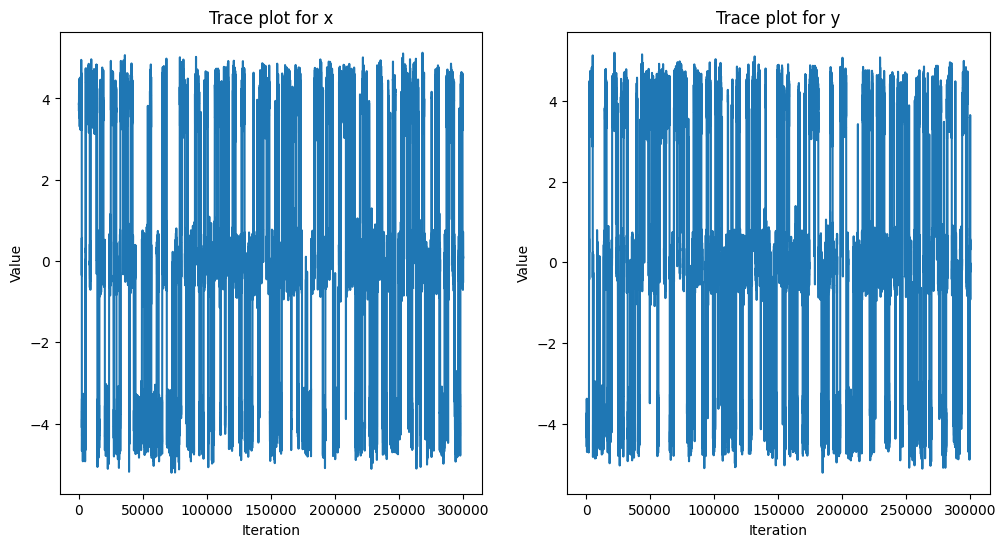

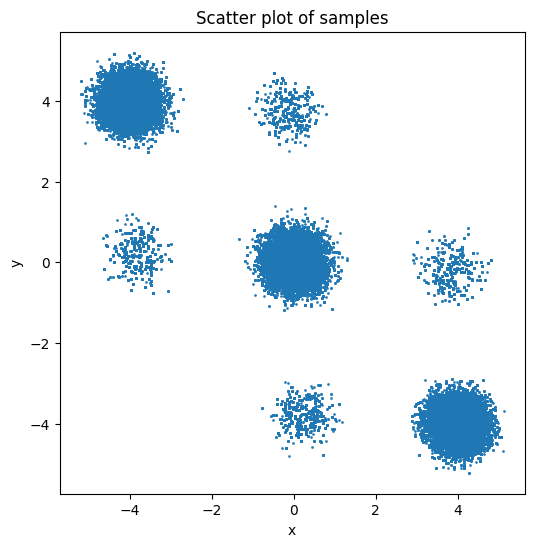

In [271]:
def gmm_prior(x, mu_list, sigma_0=0.1):
    """Compute the GMM prior density at a point x."""
    cov = sigma_0 * np.eye(2)
    prior_density = 0
    for mu in mu_list:
        diff = x - mu
        prior_density += np.exp(-0.5 * diff @ np.linalg.inv(cov) @ diff) / (2 * np.pi * np.sqrt(np.linalg.det(cov)))
    return prior_density / len(mu_list)  # Normalise by the number of components

# Define likelihood: Gaussian likelihood
def likelihood(y, x, H, sigma_y=2.0):
    """Compute the likelihood density at a point x."""
    cov = sigma_y
    mean = H @ x
    diff = y - mean
    return np.exp(-0.5 * diff**2 / cov) / np.sqrt(2 * np.pi * cov)

# Define posterior: p(x|y) ∝ p(y|x) * p(x)
def posterior(y, x, mu_list, H, sigma_0=0.1, sigma_y=2.0):
    """Compute the unnormalised posterior density."""
    return likelihood(y, x, H, sigma_y) * gmm_prior(x, mu_list, sigma_0)

# RW-MH Sampler
def rw_metropolis_sampler(y, mu_list, N, burnin, proposal_var):
    """
    Random Walk Metropolis-Hastings algorithm.

    Parameters:
        y (array): Observed data.
        mu_list (array): Means of the GMM prior components.
        N (int): Total number of samples.
        burnin (int): Number of samples to discard as burn-in.
        proposal_var (float): Variance of the Gaussian proposal distribution.

    Returns:
        samples (np.array): Samples from the posterior after burn-in.
    """
    samples = []
    x_current = np.array([0.0, 0.0])  # Initial sample
    H = np.array([1.0, 1.0])  # Linear measurement model
    acceptance = 0
    while len(samples) < N+ burnin:
        # Propose a new sample
        x_proposed = x_current + np.random.normal(0, np.sqrt(proposal_var), size=2)
        
        # Compute the acceptance ratio
        posterior_current = posterior(y, x_current, mu_list, H)
        posterior_proposed = posterior(y, x_proposed, mu_list, H)
        alpha = min(1, posterior_proposed / posterior_current)  # Compute acceptance probability
        
        # Accept or reject the proposal
        if np.random.rand() < alpha:
            x_current = x_proposed
            acceptance += 1
        samples.append(x_current)

    print(f"the acceptance rate is {acceptance/N}")
    # Discard burn-in samples
    return np.array(samples[burnin:])

# Define GMM means
mu_list = np.array([[4, 0], [0, 4], [-4, 0], [0, -4], [4, 4], [4, -4], [-4, 4], [-4, -4], [0, 0]])

# Define observe data y
y = 0  # Observed value

# Run RW-MH sampler
N = 300000
burnin = 20000
proposal_var = 3
samples = rw_metropolis_sampler(y, mu_list, N, burnin, proposal_var)

# Plotting
# Trace plot for x and y components
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(samples[:, 0], label='x')
plt.title('Trace plot for x')
plt.xlabel('Iteration')
plt.ylabel('Value')

plt.subplot(1, 2, 2)
plt.plot(samples[:, 1], label='y')
plt.title('Trace plot for y')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.show()

# Scatter plot of samples
plt.figure(figsize=(6, 6))
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.9, s=1)
plt.title('Scatter plot of samples')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


#### Discussion of the results

we note that the density is higher for values where $H\cdot\mu_i = 0$ as this occurs for 3 out the 9 $\mu$ values in our list. Likewise there are 2 instances where the  $H\cdot\mu_i = 4$ and another 2 for  $H\cdot\mu_i = -4$ then we have the lowest of densities around $H\cdot\mu_i = 8$ and $H\cdot\mu_i = -8$ since there is only one instance of each.

## 2.3


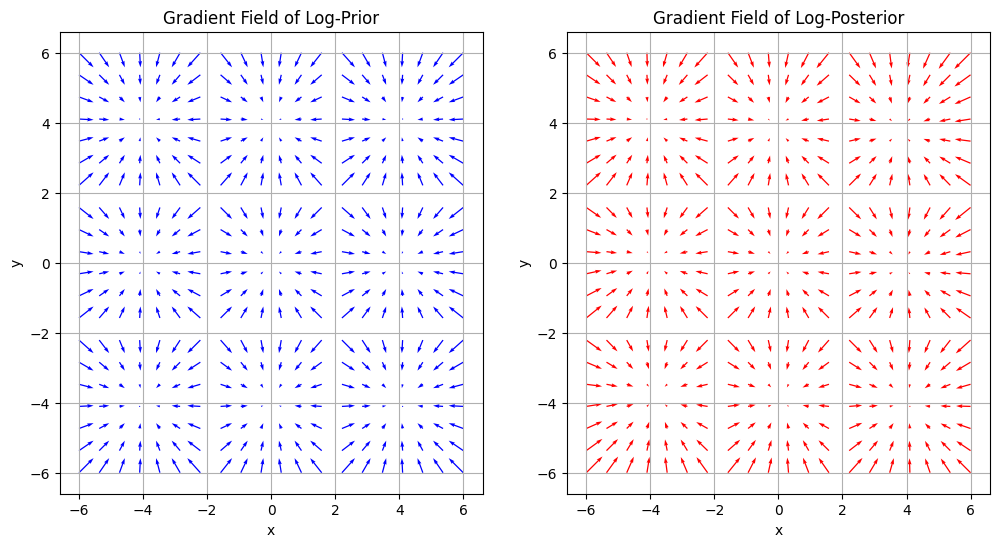

In [269]:
# Gradient of log-prior
def grad_log_prior(x, mu_list, sigma_0=0.1):
    cov_inv = np.eye(2) / sigma_0
    numerator = np.zeros_like(x)
    denominator = 0
    for mu in mu_list:
        w = np.exp(-0.5 * (x - mu) @ cov_inv @ (x - mu))
        numerator += w * (-cov_inv @ (x - mu))
        denominator += w
    return numerator / denominator if denominator != 0 else np.zeros_like(x)

# Gradient of log-likelihood
def grad_log_likelihood(y, x, H, sigma_y=2.0):
    """Compute gradient of the log-likelihood."""
    Hx = H @ x  # Compute scalar prediction
    return H * (y - Hx) / sigma_y**2  # Broadcast correctly


def grad_log_posterior(y, x, mu_list, H, sigma_0=0.1, sigma_y=2.0):
    """Compute gradient of the log-posterior."""
    return grad_log_likelihood(y, x, H, sigma_y) + grad_log_prior(x, mu_list, sigma_0)

y=0 # orgin at 0
# Create meshgrid for visualisation
grid = np.linspace(-6, 6, 20)
X, Y = np.meshgrid(grid, grid)
U_prior, V_prior = np.zeros_like(X), np.zeros_like(Y)
U_posterior, V_posterior = np.zeros_like(X), np.zeros_like(Y)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        point = np.array([X[i, j], Y[i, j]])
        grad_prior = grad_log_prior(point, mu_list)
        grad_post = grad_log_posterior(y, point, mu_list, H=np.array([1.0, 1.0]))
        U_prior[i, j], V_prior[i, j] = grad_prior
        U_posterior[i, j], V_posterior[i, j] = grad_post
precision = 100
# Plot gradient fields
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.quiver(X, Y, U_prior, V_prior, color='blue')
plt.title("Gradient Field of Log-Prior")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()

plt.subplot(1, 2, 2)
plt.quiver(X, Y, U_posterior, V_posterior, color='red')
plt.title("Gradient Field of Log-Posterior")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.show()



In [ ]:
def mala_sampler(y, mu_list, N, burnin, epsilon, sigma_0=0.1, sigma_y=2.0):
    samples = []
    x_current = np.array([0.0, 0.0])  # Start at origin
    H = np.array([1.0, 1.0])         # Linear measurement model
    
    while len(samples) < (N + burnin):
        grad_prior = grad_log_prior(x_current, mu_list, sigma_0)
        grad_likelihood = grad_log_likelihood(y, x_current, H, sigma_y)
        grad_posterior = grad_prior + grad_likelihood

        noise = np.random.normal(0, 1, size=2)
        x_proposed = x_current + epsilon * grad_posterior + np.sqrt(2 * epsilon) * noise

        # Compute acceptance probability
        current_density = np.exp(-0.5 * np.linalg.norm(H @ x_current - y)**2 / sigma_y**2)
        proposed_density = np.exp(-0.5 * np.linalg.norm(H @ x_proposed - y)**2 / sigma_y**2)
        acceptance_ratio = proposed_density / current_density

        if np.random.rand() < acceptance_ratio:
            x_current = x_proposed

        samples.append(x_current)
    
    return np.array(samples[burnin:])

samples = mala_sampler(y, mu_list, N=100000, burnin=1000, epsilon=0.01)


discussing 2.3

#### 2.4

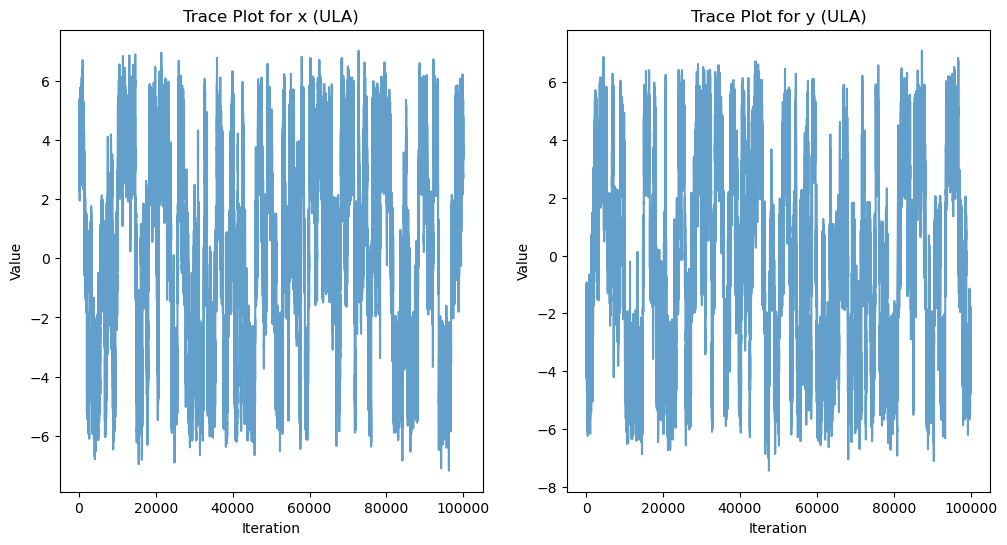

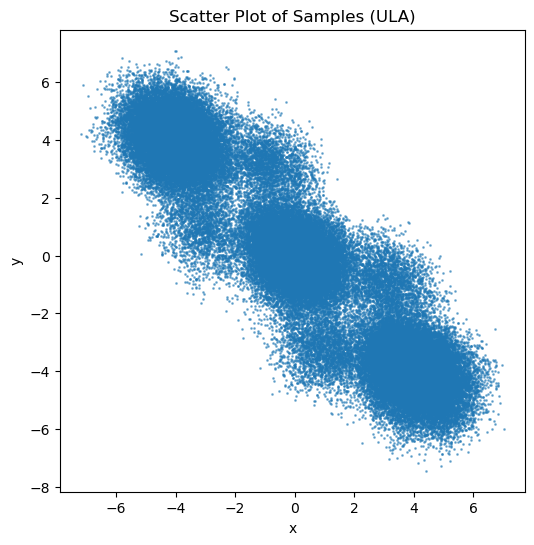

In [5]:


# ULA sampler
def ula_sampler(y, mu_list, N, burnin, epsilon, sigma_0=0.1, sigma_y=2.0):
    samples = []
    x_current = np.array([0.0, 0.0])  # Start at origin
    H = np.array([1.0, 1.0])         # Linear measurement model
    
    while len(samples ) < (N + burnin):
        # Compute gradients
        grad_prior = grad_log_prior(x_current, mu_list, sigma_0)
        grad_likelihood = grad_log_likelihood(y, x_current, H, sigma_y)
        
        # Langevin update
        noise = np.random.normal(0, 1, size=2)
        x_current = x_current + epsilon * (grad_likelihood + grad_prior) + np.sqrt(2 * epsilon) * noise
        
        samples.append(x_current)
    
    return np.array(samples[burnin:])  # Discard burn-in samples

# GMM prior means
mu_list = np.array([[4, 0], [0, 4], [-4, 0], [0, -4], [4, 4], [4, -4], [-4, 4], [-4, -4], [0, 0]])

# Observed data
y = 0

# Run ULA sampler
N = 100000
burnin = 10000
epsilon =  0.14 # Step size
samples_ula = ula_sampler(y, mu_list, N, burnin, epsilon)

# Plotting
# Trace plots for x and y components
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(samples_ula[:, 0], alpha=0.7)
plt.title('Trace Plot for x (ULA)')
plt.xlabel('Iteration')
plt.ylabel('Value')

plt.subplot(1, 2, 2)
plt.plot(samples_ula[:, 1], alpha=0.7)
plt.title('Trace Plot for y (ULA)')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.show()

# Scatter plot of samples
plt.figure(figsize=(6, 6))
plt.scatter(samples_ula[:, 0], samples_ula[:, 1], alpha=0.5, s=1)
plt.title('Scatter Plot of Samples (ULA)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Q2.4 discussion

### Q2.5 Importance Sampling-Resampling Estimator for $p(x|y)$

We aim to implement an **Importance Sampling-Resampling Estimator** for the posterior distribution $p(x|y)$.

---

## Problem Setup

The Gaussian posterior is defined as:

$$
p(x|y) \propto \mathcal{N}(x; \mu_p, \sigma_p^2),
$$

where:

$$
\mu_p = \frac{\sigma_0^2 \sum_{i=1}^n y_i + \sigma^2 \mu_0}{\sigma_0^2 n + \sigma^2},
\quad 
\sigma_p^2 = \frac{\sigma_0^2 \sigma^2}{\sigma_0^2 n + \sigma^2}.
$$

For this task, we assume $\mu_0 = 0$, $\sigma_0^2 = 1$, and $\sigma^2 = 1$, simplifying $\mu_p$ to:

$$
\mu_p = \frac{\sum_{i=1}^n y_i}{n + 1}.
$$

---

## Implementation Steps

### **1. Simulate Data**

We generate $M = 100$ observations $y_1, y_2, \dots, y_M$:

Analytic posterior mean: 0.5173374365402565
Mean estimate (SNIS): 0.5171855472026013
Effective Sample Size (ESS): 12316.621236054374


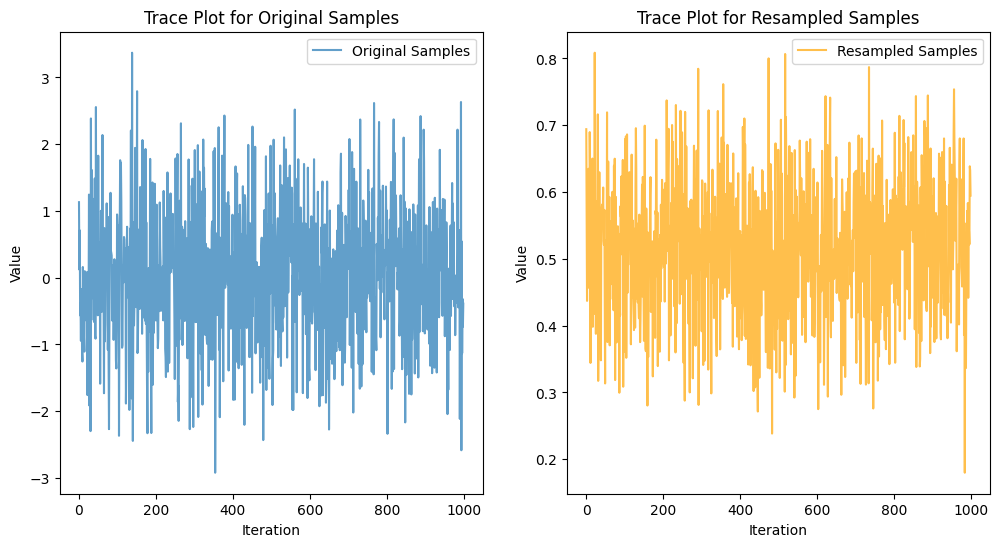

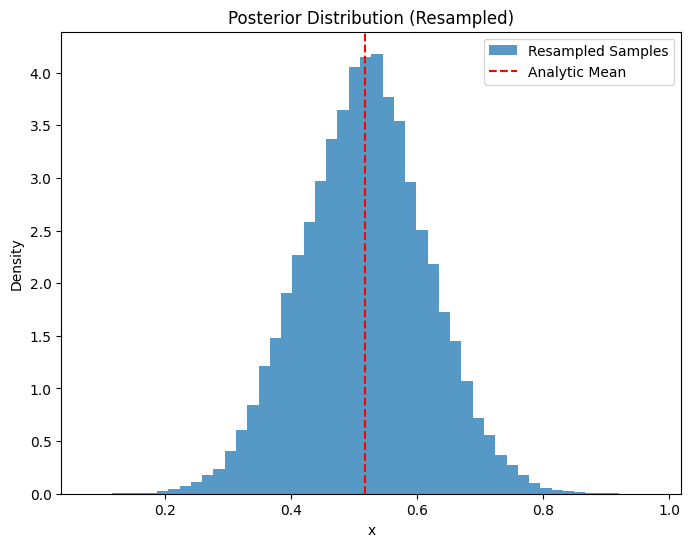

In [255]:
# Simulate data
M = 100  # Number of data points
rng = np.random.default_rng(25)
x_true = rng.normal(0, 1)  # True underlying parameter
y = rng.normal(x_true, 1, M)  # Observations

# Analytic posterior mean
mean_true = np.sum(y) / (M + 1)
print("Analytic posterior mean:", mean_true)

# Define log densities
def logp(x):
    """Log-prior: Gaussian(0, 1)."""
    return -x**2 / 2 - np.log(np.sqrt(2 * np.pi))

def loglik(x, y):
    """Log-likelihood: Gaussian(x, 1)."""
    return -np.sum((x - y)**2) / 2 - M * np.log(np.sqrt(2 * np.pi))

def logq(x):
    """Log-proposal: Gaussian(0, 1)."""
    return -x**2 / 2 - np.log(np.sqrt(2 * np.pi))

def ESS(weights):
    """Effective Sample Size (ESS)."""
    return 1 / np.sum(weights**2)

# SNIS Implementation with log-sum-exp
N = 100000  # Number of samples
x_samples = rng.normal(0, 1, N)  # Sample from q(x)
log_weights = np.zeros(N)

# Compute log weights
for i in range(N):
    log_weights[i] = loglik(x_samples[i], y) + logp(x_samples[i]) - logq(x_samples[i])

# Stabilise weights using log-sum-exp
log_max = np.max(log_weights)  # Maximum log-weight for numerical stability
weights = np.exp(log_weights - log_max)  # Subtract log_max to stabilize
weights /= np.sum(weights)  # Normalise to sum to 1

# Mean estimate and ESS
mean_estimate = np.sum(weights * x_samples)
effective_sample_size = ESS(weights)
print("Mean estimate (SNIS):", mean_estimate)
print("Effective Sample Size (ESS):", effective_sample_size)

# Resampling
resampled_indices = rng.choice(np.arange(N), size=N, p=weights)
resampled_samples = x_samples[resampled_indices]

# Trace plots for samples
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(x_samples[:1000], alpha=0.7, label="Original Samples")
plt.title('Trace Plot for Original Samples')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(resampled_samples[:1000], alpha=0.7, label="Resampled Samples", color='orange')
plt.title('Trace Plot for Resampled Samples')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.legend()
plt.show()

# Histogram of resampled samples
plt.figure(figsize=(8, 6))
plt.hist(resampled_samples, bins=50, density=True, alpha=0.75, label="Resampled Samples")
plt.axvline(mean_true, color='red', linestyle='--', label="Analytic Mean")
plt.title("Posterior Distribution (Resampled)")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.show()